#  Proje Amacı

Bu projede, bir oyuncunun sezonluk performans verilerine dayanarak MVP (En Değerli Oyuncu) olma olasılığını tahmin etmeyi amaçlıyoruz.

- Sezon istatistikleri verisi **Kaggle** platformundan alınmıştır.
- MVP bilgileri ise **Wikipedia** üzerinden web kazıma (scraping) yöntemiyle elde edilmiştir.


# Import Libraries & data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# preprocess, metrics, feature
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
# streamlit
import joblib
import streamlit as st

In [2]:
seasons = pd.read_csv('Seasons_Stats.csv')
player_mvp = pd.read_csv('NBA_MVP.csv')

# Ön İşleme


## Eksik Değerleri Kontrol Etme


In [3]:
seasons.isnull().sum()

Unnamed: 0        0
Year             67
Player           67
Pos              67
Age              75
Tm               67
G                67
GS             6458
MP              553
PER             590
TS%             153
3PAr           5852
FTr             166
ORB%           3899
DRB%           3899
TRB%           3120
AST%           2136
STL%           3899
BLK%           3899
TOV%           5109
USG%           5051
blanl         24691
OWS             106
DWS             106
WS              106
WS/48           590
blank2        24691
OBPM           3894
DBPM           3894
BPM            3894
VORP           3894
FG               67
FGA              67
FG%             166
3P             5764
3PA            5764
3P%            9275
2P               67
2PA              67
2P%             195
eFG%            166
FT               67
FTA              67
FT%             925
ORB            3894
DRB            3894
TRB             379
AST              67
STL            3894
BLK            3894


In [4]:
player_mvp.isnull().sum()

Year           0
 Player        0
 Position      0
 Team          0
Unnamed: 4    62
dtype: int64

## Eksik Değerlerin ve Tarihin Kaldırılması
1. Blank1 ve Blank2 sütunları tamamen eksik verilere sahiptir.
2. Sezonlar verisinde eksik olan oyuncular çıkarılmıştır.
3. MVP'nin tanıtılmadan önceki yıllar kaldırılmıştır.
4. Yıl verisi **float** türünden **int** türüne dönüştürülmüştür.
5. HOF oyuncularının isimleri (asterisk *) kaldırılmıştır.


In [5]:
# drop blanl & blank2, and any missing players
seasons.drop(['blanl', 'blank2', 'Unnamed: 0'], axis=1, inplace=True)
seasons = seasons[~seasons['Player'].isnull()]
player_mvp.drop('Unnamed: 4', axis=1, inplace=True)
# change data to int
seasons['Year'] = seasons['Year'].astype('int')
# drop all data before 1956
seasons = seasons[seasons['Year']>= 1956]
# trim column name
player_mvp.columns = player_mvp.columns.str.strip()
# remove asterik from player column
seasons['Player'] = seasons['Player'].str.replace(r'\*$','', regex=True)
# remove trailing spaces
player_mvp['Player'] = player_mvp['Player'].str.strip()

## Eksik Değerler



In [6]:
print('En az bir eksik değere sahip satırların yüzdesi, toplam satır sayısının %{:.2f}’sidir\n'
      .format(100 * seasons.isnull().any(axis=1).sum().sum() / seasons.shape[0]))


En az bir eksik değere sahip satırların yüzdesi, toplam satır sayısının %38.22’sidir



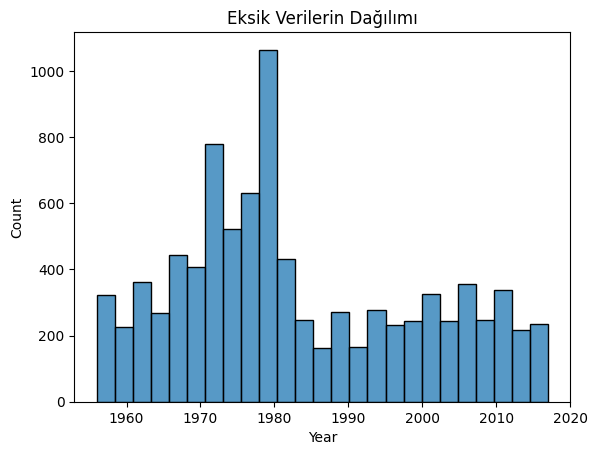

In [7]:
df_missing = seasons[seasons.isnull().any(axis=1)]
# Yıla göre eksik verileri kontrol et
sns.histplot(data=df_missing, x='Year')
plt.title("Eksik Verilerin Dağılımı")
plt.show()

Çoğu eksik değer 1956 ile 1980 yılları arasında meydana gelmiştir.


In [8]:
# 1956-1980 arası ve sonrası için eksik veri oranını hesapla
seasons_bef = seasons[seasons["Year"] <= 1980]
seasons_aft = seasons[seasons["Year"] > 1980]
print("1956 - 1980 arasındaki satırlarda en az bir eksik veri yüzdesi %{:.2f}\n\n"
      .format(100*seasons_bef.isnull().any(axis=1).sum().sum()/seasons_bef.shape[0]))

print("1980 sonrası satırlarda en az bir eksik veri yüzdesi %{:.2f}\n\n"
      .format(100*seasons_aft.isnull().any(axis=1).sum().sum()/seasons_aft.shape[0]))


1956 - 1980 arasındaki satırlarda en az bir eksik veri yüzdesi %99.78


1980 sonrası satırlarda en az bir eksik veri yüzdesi %21.52




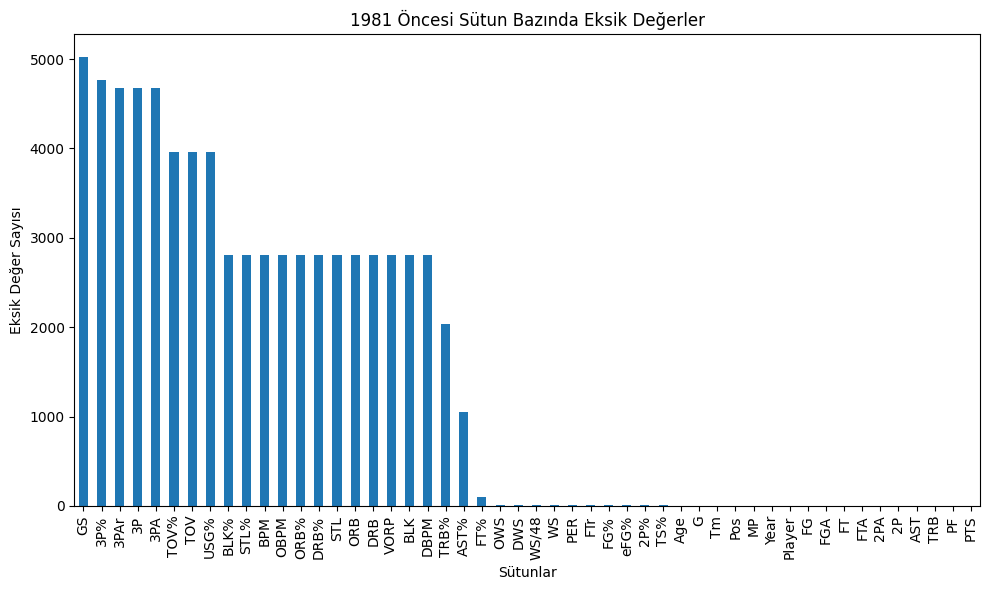

In [9]:
# 1981 öncesi eksik değerler
missing_df = seasons_bef.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
missing_df.plot(kind='bar')
plt.title('1981 Öncesi Sütun Bazında Eksik Değerler')
plt.ylabel('Eksik Değer Sayısı')
plt.xlabel('Sütunlar')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


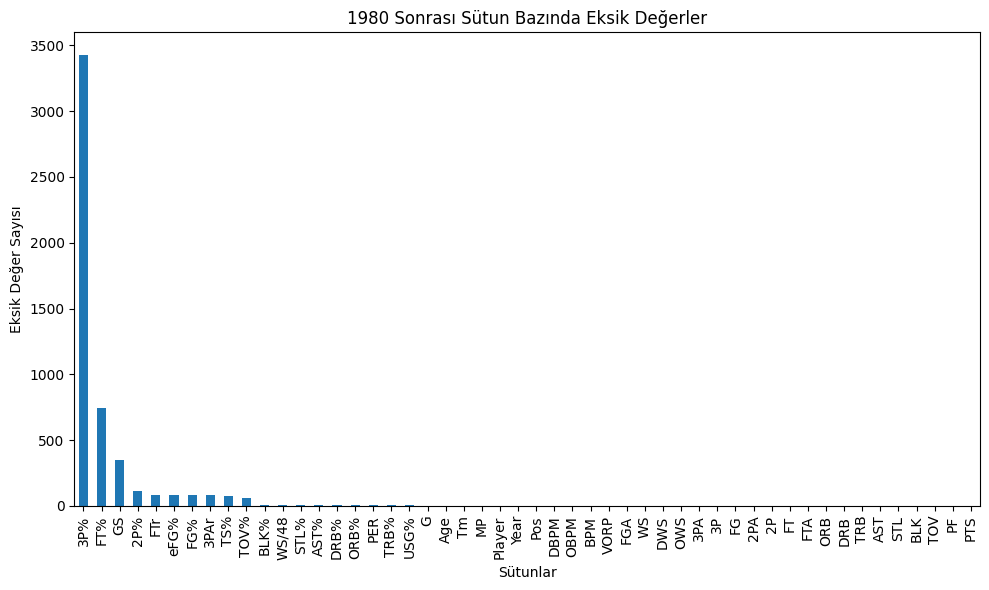

In [10]:
# 1980 sonrası eksik değerler
missing_df = seasons_aft.isnull().sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
missing_df.plot(kind='bar')
plt.title('1980 Sonrası Sütun Bazında Eksik Değerler')
plt.ylabel('Eksik Değer Sayısı')
plt.xlabel('Sütunlar')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


1981'den önceki eksik verilerin çoğunun, o dönemde tanıtılmayan özelliklerden kaynaklandığı görülmektedir.

Bu durum, eksik verilerin normal dağılım göstermediğini ve bu sütunları düşürmeyi düşünmemiz gerekebileceğini gösteriyor. Aksi takdirde, herhangi bir doğru model oluşturmak için bias (önyargı) sorunları yaşayabiliriz.

1980 sonrası 3P% dağılımını kontrol etmemiz ve bu özelliğin hangi yılda tanıtıldığını incelememiz gerekmektedir.


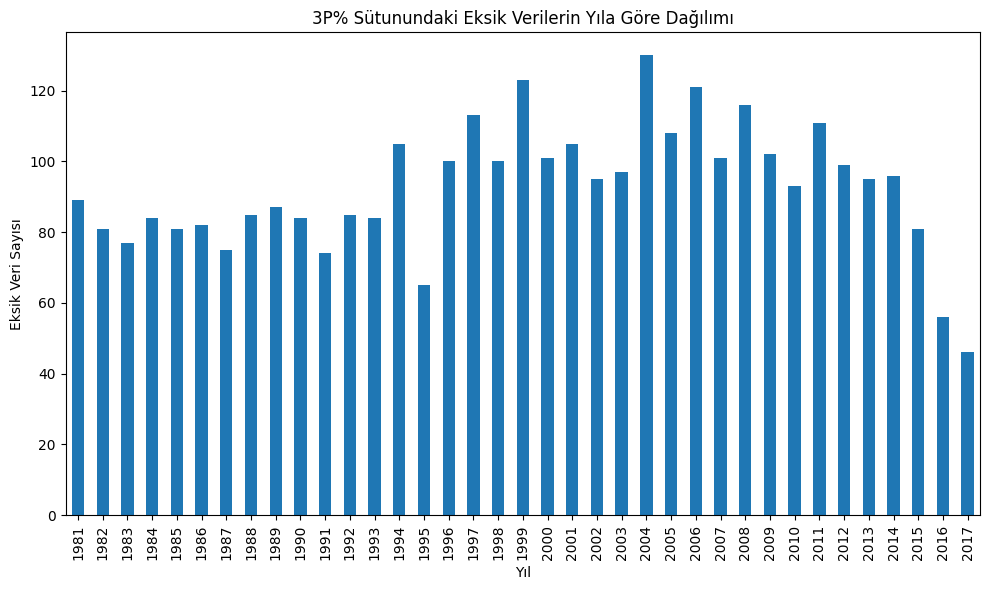

In [11]:
# 1980 sonrası 3P% sütununu kontrol etme
missing_by_year = seasons_aft[seasons_aft['3P%'].isnull()].groupby('Year').size().sort_index()
plt.figure(figsize=(10, 6))
missing_by_year.plot(kind='bar')
plt.title('3P% Sütunundaki Eksik Verilerin Yıla Göre Dağılımı')
plt.xlabel('Yıl')
plt.ylabel('Eksik Veri Sayısı')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


1980 sonrası 3P% verisinin eksik verilerinin normal dağılım gösterdiği ve yıl bazında rastlantısal olarak ilişkilendirilebileceği görünmektedir.

Diğer değişkenleri kontrol etmeli ve 3P%'nin neden bu kadar eksik veri içerdiğini araştırmalıyız.


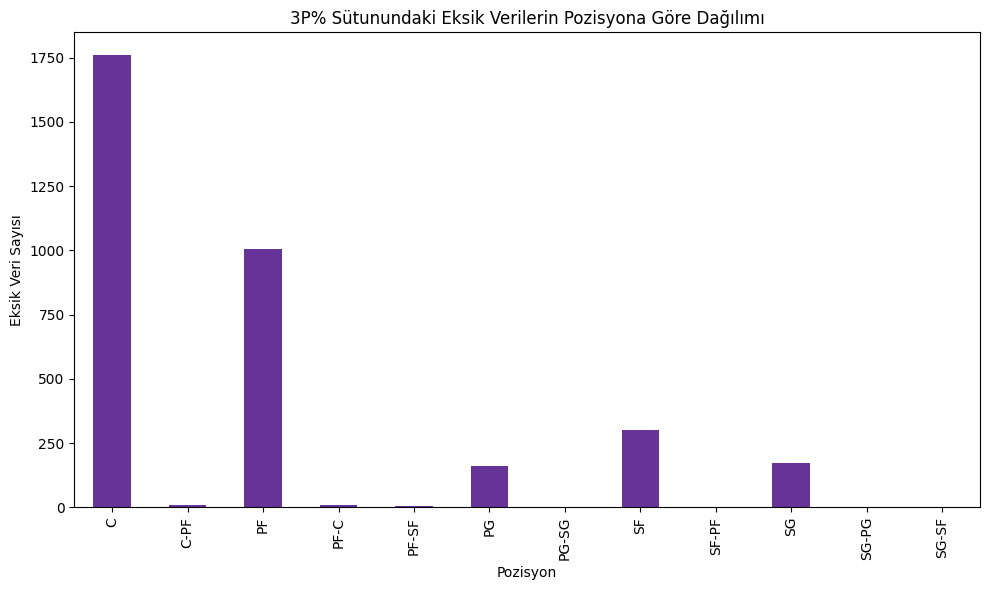

In [12]:
# 1980 sonrası 3P% sütununu pozisyona göre kontrol etme
missing_by_year = seasons_aft[seasons_aft['3P%'].isnull()].groupby('Pos').size().sort_index()
plt.figure(figsize=(10, 6))
missing_by_year.plot(kind='bar', color='rebeccapurple')
plt.title('3P% Sütunundaki Eksik Verilerin Pozisyona Göre Dağılımı')
plt.xlabel('Pozisyon')
plt.ylabel('Eksik Veri Sayısı')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Eksik verilerin çoğu ya Center (C) ya da Power Forward (PF) pozisyonlarından gelmektedir. 

3P%, üç sayılık atışlardan başarılı olanların toplam üç sayılık atış denemelerine oranıdır.

3P% = 3P / 3PA ve bu özellik yalnızca 1979-1980 sezonunda tanıtılmıştır.


### Shaquille O'Neal İsmini Düzeltme


In [13]:
player_mvp['Player'] = player_mvp['Player'].str.replace('’', "'", regex=False)
player_mvp[player_mvp['Player'].str.contains('Shaquille')]

,Year,Player,Position,Team
17,2000,Shaquille O'Neal,C,Los Angeles Lakers


# Keşifsel Veri Analizi (EDA)


## MVP Sütunu Oluşturma


In [14]:
# season ve player_mvp veri setlerini birleştir ve mvp sütunu oluştur
df = pd.merge(left=seasons, right=player_mvp, how='left', on=['Player', 'Year'])
df['MVP'] = (~df['Position'].isnull())  # MVP olup olmadığını kontrol et
df['MVP'].value_counts()  # MVP sayısını kontrol et

# mvp veri setindeki ekstra iki sütunu kaldır
df.drop(['Position', 'Team'], axis=1, inplace=True)

# MVP sütununu 1 ve 0 olarak dönüştür
df['MVP'] = df['MVP'].astype(int)


## Veriyi MVP ve Non-MVP Olarak Ayırma


In [15]:
# mvp players that won
mvp = df[df['MVP'] == 1].copy()
# non-mvp players
nonmvp = df[df['MVP'] == 0].copy()

In [16]:
mvp.describe()

,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MVP
count,62.000000,62.000000,62.000000,36.000000,62.000000,62.000000,62.000000,38.000000,62.000000,44.000000,...,44.000000,44.000000,62.000000,62.000000,44.000000,44.000000,40.000000,62.000000,62.000000,62.0
mean,1986.500000,27.258065,78.016129,78.111111,3075.967742,26.156452,0.569532,0.133632,0.414452,6.852273,...,182.772727,560.818182,959.596774,428.983871,120.840909,110.931818,251.350000,197.500000,2028.177419,1.0
std,18.041619,2.963911,6.255468,6.300920,385.044897,3.667519,0.050631,0.138342,0.113370,3.966047,...,124.006538,214.199784,494.429178,217.929263,46.855018,92.398630,48.363766,50.959563,467.232926,0.0
min,1956.000000,22.000000,49.000000,49.000000,1832.000000,18.100000,0.452000,0.001000,0.160000,1.900000,...,47.000000,192.000000,249.000000,101.000000,36.000000,6.000000,162.000000,96.000000,1097.000000,1.0
25%,1971.250000,25.000000,78.000000,77.000000,2879.250000,24.250000,0.550500,0.013750,0.348500,4.375000,...,96.250000,391.000000,527.250000,284.000000,84.000000,41.500000,225.250000,158.500000,1786.000000,1.0
50%,1986.500000,27.000000,80.000000,80.000000,3089.500000,26.700000,0.576500,0.097500,0.417000,5.800000,...,138.000000,555.500000,870.500000,378.000000,122.500000,74.500000,248.500000,198.500000,2035.000000,1.0
75%,2001.750000,29.000000,82.000000,81.000000,3335.750000,28.750000,0.604000,0.240250,0.480750,9.100000,...,244.250000,726.250000,1192.500000,530.000000,141.750000,161.250000,272.250000,229.750000,2338.750000,1.0
max,2017.000000,35.000000,82.000000,82.000000,3836.000000,31.700000,0.669000,0.554000,0.761000,19.200000,...,587.000000,1111.000000,1957.000000,988.000000,259.000000,338.000000,438.000000,311.000000,2868.000000,1.0


In [17]:
nonmvp.describe()

,Year,Age,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,MVP
count,23546.000000,23541.000000,23546.000000,18197.000000,23546.000000,23529.000000,23461.000000,18801.000000,23448.000000,20748.000000,...,20753.000000,20753.000000,23546.000000,23546.000000,20753.000000,20753.000000,19605.000000,23546.000000,23546.000000,23546.0
mean,1994.364775,26.687779,50.969082,23.485520,1203.488915,12.452582,0.496783,0.158655,0.321092,6.180143,...,61.933552,146.322459,222.192602,114.682451,39.725437,24.286946,73.577863,115.559628,511.063493,0.0
std,15.563250,3.875194,26.586483,28.556387,937.900217,5.985583,0.092962,0.187580,0.219312,4.874408,...,66.929001,144.498353,223.891066,136.207815,38.515033,36.517373,67.271911,84.612232,491.525968,0.0
min,1956.000000,18.000000,1.000000,0.000000,0.000000,-90.600000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1983.000000,24.000000,27.000000,0.000000,338.000000,9.800000,0.463000,0.005000,0.204750,2.600000,...,12.000000,33.000000,51.000000,19.000000,9.000000,3.000000,18.000000,39.000000,106.000000,0.0
50%,1997.000000,26.000000,57.000000,8.000000,1046.000000,12.700000,0.508000,0.064000,0.292000,5.400000,...,38.000000,106.000000,158.000000,67.000000,29.000000,11.000000,55.000000,107.000000,365.000000,0.0
75%,2008.000000,29.000000,76.000000,45.000000,1961.750000,15.600000,0.545000,0.288000,0.395000,9.000000,...,91.000000,211.000000,319.000000,160.000000,60.000000,29.000000,112.000000,181.000000,783.000000,0.0
max,2017.000000,44.000000,88.000000,83.000000,3882.000000,129.100000,1.136000,1.000000,6.000000,100.000000,...,573.000000,1109.000000,2149.000000,1164.000000,301.000000,456.000000,464.000000,386.000000,4029.000000,0.0


## Pozisyona Dayalı Analiz


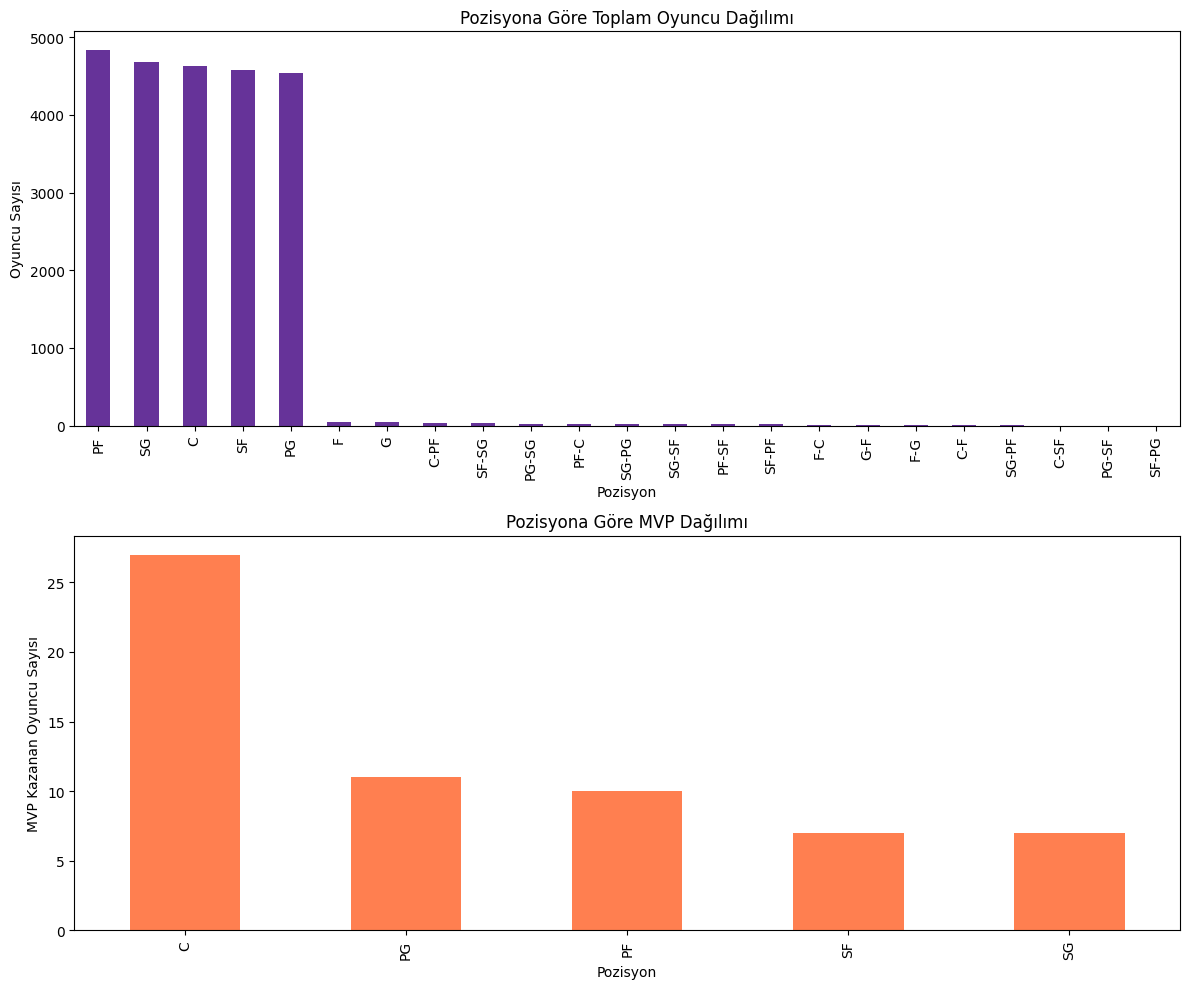

In [18]:
# Pozisyona göre MVP sayısı
mvp_pos = mvp.groupby('Pos').size().sort_values(ascending=False)
df_pos = df.groupby('Pos').size().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

# 1. alt grafik: Toplam oyuncu dağılımı
df_pos.plot(kind='bar', ax=axes[0], color="rebeccapurple")
axes[0].set_title('Pozisyona Göre Toplam Oyuncu Dağılımı')
axes[0].set_xlabel('Pozisyon')
axes[0].set_ylabel('Oyuncu Sayısı')

# 2. alt grafik: MVP dağılımı
mvp_pos.plot(kind='bar', ax=axes[1], color="coral")
axes[1].set_title('Pozisyona Göre MVP Dağılımı')
axes[1].set_xlabel('Pozisyon')
axes[1].set_ylabel('MVP Kazanan Oyuncu Sayısı')

plt.tight_layout()
plt.show()


Oyunu kazanan oyuncuların çoğu Center (C) pozisyonundadır.

Diğer pozisyonlar ise birbirleri arasında normal dağılım göstermektedir.


## Kazanan Oyunculara Dayalı Analiz


C:\Users\HP\AppData\Local\Temp\ipykernel_7404\3382503306.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=mvp, y="Pos", x="Year", palette="Set2")


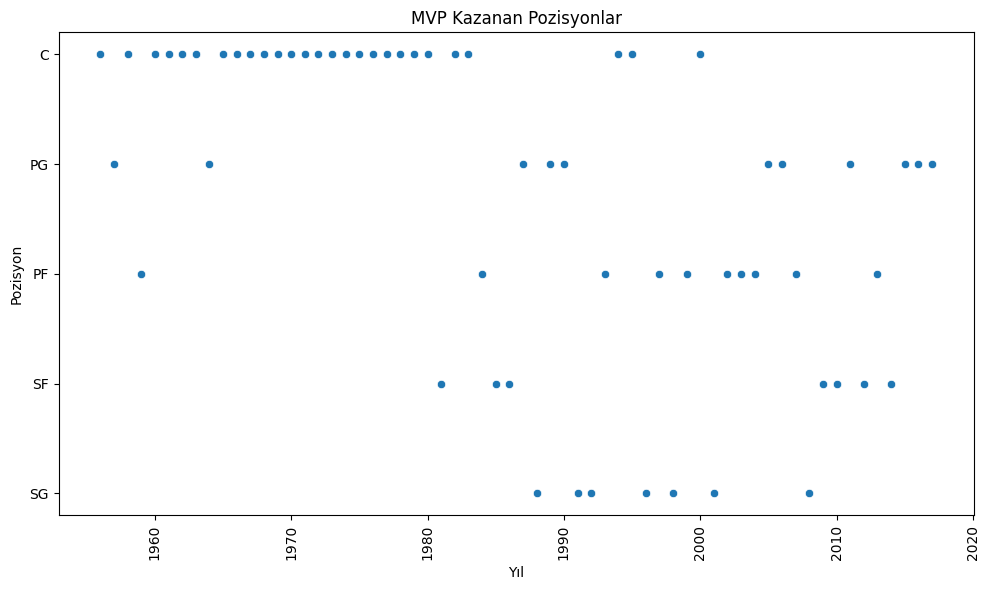

In [19]:
# MVP'yi oyuncuya göre gruplama
mvp_year = mvp.groupby('Year').size().sort_values(ascending=False)
plt.figure(figsize=(10, 6))

# MVP kazanan pozisyonları görselleştirme
sns.scatterplot(data=mvp, y="Pos", x="Year", palette="Set2")
plt.title('MVP Kazanan Pozisyonlar')
plt.xlabel('Yıl')
plt.ylabel('Pozisyon')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


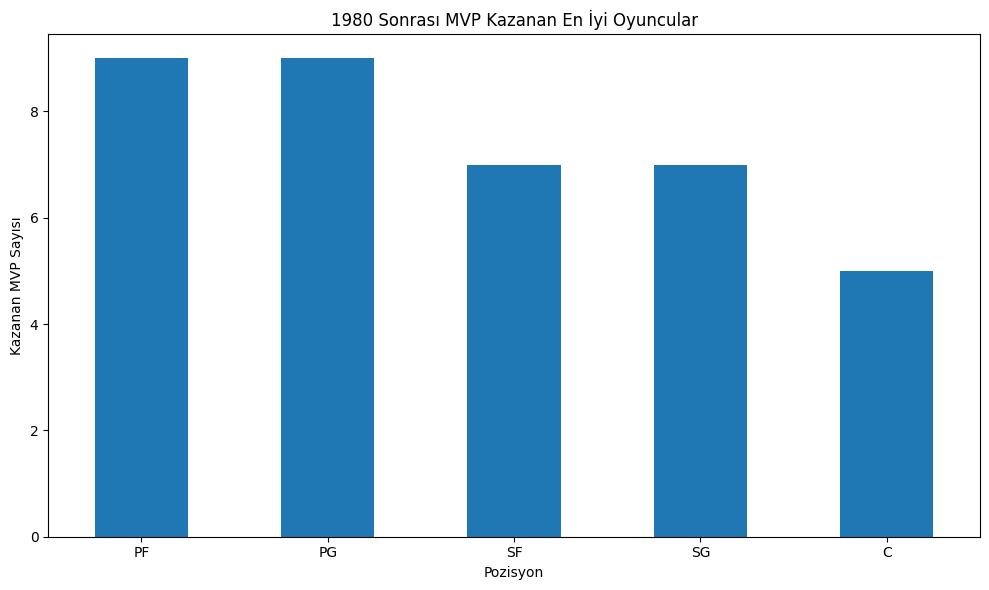

In [20]:
# 1980 sonrası pozisyona göre MVP dağılımı
mvp_pos = mvp[mvp['Year'] > 1980].groupby('Pos').size().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
mvp_pos.plot(kind='bar')
plt.title('1980 Sonrası MVP Kazanan En İyi Oyuncular')
plt.xlabel('Pozisyon')
plt.ylabel('Kazanan MVP Sayısı')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


MVP kazanan oyuncuların çoğunun Center pozisyonunda olduğu ve bu durumun 1980'den önce yoğunlaştığı, sonrasında ise daha rastlantısal bir dağılım gösterdiği görülmektedir.


## Veriyi Kaldırma
1981'den önceki yılları çıkaracağız.

3P% sütununu kaldırıyoruz.


In [21]:
df_clean = df[df["Year"] > 1980 ]
df_clean = df_clean.drop("3P%", axis=1).copy().reset_index()


# Normalizasyon
Yıl, yaş ve MVP verilerini normalize etmeyeceğiz.


In [22]:
numeric_cols = df_clean.select_dtypes(include='number').columns
numeric_cols.drop(['Year','Age','MVP'])
scaler_feature = MinMaxScaler()

In [23]:

# Redefine scaler
scaler = MinMaxScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])
X = df_clean.drop(columns=['MVP']).select_dtypes(include=['number']) 
y = df_clean['MVP']
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, stratify=y, test_size=0.3, random_state=42)

# Özellik Seçimi


## Korelasyon


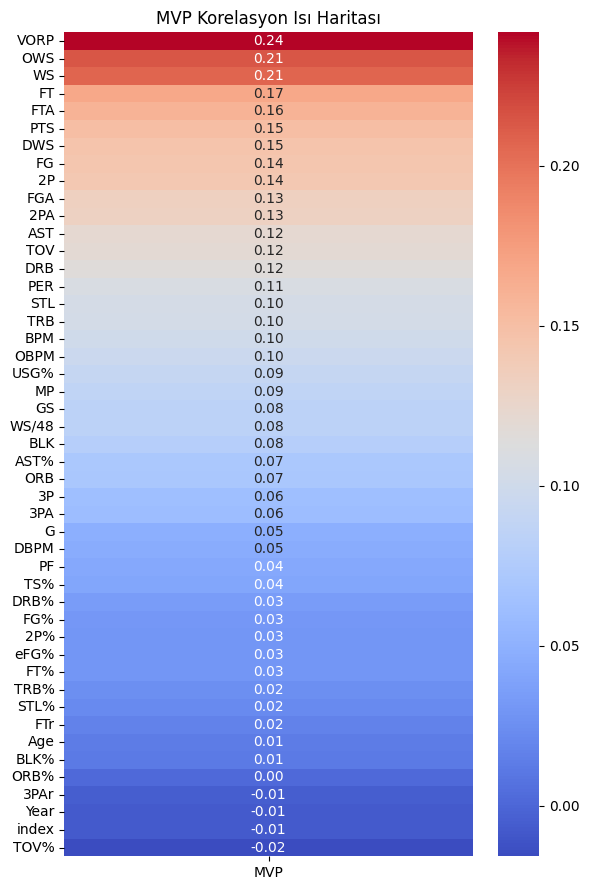

In [24]:
# Korelasyon matrisini hesapla
corr_matrix = df_clean.corr(numeric_only=True)
mvp_corr = corr_matrix[['MVP']].drop('MVP').sort_values(by='MVP', ascending=False)

# Korelasyon ısı haritasını çiz
plt.figure(figsize=(6, 9))
sns.heatmap(mvp_corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('MVP Korelasyon Isı Haritası')
plt.tight_layout()
plt.show()


## Veriyi Ayırma


In [25]:
X = df_clean.drop(columns=['MVP']).select_dtypes(include=['number']) 
y = df_clean['MVP']
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, stratify=y, test_size=0.3, random_state=42)

## Karar Ağacı


In [26]:

model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [27]:
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [28]:
# En önemli 3 özelliği al
top_n_features = feature_importance_df.head(3)['Feature'].tolist()
print("En Önemli 3 Özellik:")
print(top_n_features)


En Önemli 3 Özellik:
['PER', 'OWS', 'WS/48']


## Rastgele Orman (Random Forest)


In [29]:
model = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [30]:
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [31]:
# En önemli 3 özelliği al
top_n_features = feature_importance_df.head(3)['Feature'].tolist()
print("En Önemli 3 Özellik:")
print(top_n_features)

En Önemli 3 Özellik:
['OWS', 'WS', 'VORP']


Sonuçlanan 3 özellik seçimi modeline dayanarak, şu özellikler seçilmiştir:

**WS, VORP, OWS**
**VORP** (Value Over Replacement Player)
Türkçesi: Yedek Oyuncu Üzerinden Değer
Ne ölçer?
Bir oyuncunun ortalama bir yedek oyuncuya göre takıma kattığı değeri gösterir.

Pozisyon ve oynama süresi göz önünde bulundurularak hesaplanır.

NBA'de ortalama bir yedek oyuncu "0.0" VORP'a sahiptir.

Yüksek VORP = Takıma daha fazla katkı.

Örnek: LeBron James'in sezonluk VORP'u 7.5 ise, bu onun lig ortalamasının çok üzerinde katkı sunduğunu gösterir.

**WS** (Win Shares)
Türkçesi: Galibiyet Katkısı
Ne ölçer?
Bir oyuncunun takımının galibiyetlerine katkısını sayısal olarak ifade eder.

Takımın galibiyet sayısının bir oyuncuya ne kadar "paylaştırılabileceğini" gösterir.

Hem hücum hem savunma performansına dayalıdır.

 Örnek: 10 WS değeri olan bir oyuncu, sezon boyunca takımın yaklaşık 10 galibiyetine doğrudan katkı sağlamış demektir.

 **OWS** (Offensive Win Shares)
Türkçesi: Hücum Galibiyet Katkısı
Ne ölçer?
Oyuncunun sadece hücumdaki katkısını ölçen WS’in alt kalemidir.

Sayı üretimi, asist, verimli şut kullanımı gibi hücum istatistikleri dikkate alınır.

OWS + DWS (Defensive Win Shares) = Toplam WS

# Model Eğitimi


Önemli olan özellikler seçildi.

Veri normalizasyonu yapıldı.

In [32]:
# Seçilen özellikler için veriyi normalize etme
numeric_cols = ['WS','OWS','VORP']
scaler = MinMaxScaler() #  Streamlit için 
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])
df_select = df_clean[numeric_cols].copy()

In [33]:
# Veriyi ayır
X = df_select  # Özellikler (input verisi)
y = df_clean['MVP']  # Hedef değişken (MVP)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, stratify=y, test_size=0.3, random_state=42)

## Regresyon


In [34]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X, y)
y_pred = model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [35]:
# Hassasiyet, özgüllük ve doğruluk hesaplamaları
sensitivity = tp / (tp + fn)  # Hassasiyet (Recall) hesapla
specificity = tn / (tn + fp)  # Özgüllük (Specificity) hesapla
precision = tp / (tp + fp)  # Doğruluk (Precision) hesapla

# Sonuçları yazdır
print(f"Hassasiyet (Recall): {sensitivity:.3f}")
print(f"Özgüllük (Specificity): {specificity:.3f}")
print(f"Doğruluk (Precision): {precision:.3f}")
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred, digits=3))  # Sınıflandırma raporunu yazdır


Hassasiyet (Recall): 1.000
Özgüllük (Specificity): 0.974
Doğruluk (Precision): 0.071

Sınıflandırma Raporu:

              precision    recall  f1-score   support

         0.0      1.000     0.974     0.987      5560
         1.0      0.071     1.000     0.132        11

    accuracy                          0.974      5571
   macro avg      0.535     0.987     0.559      5571
weighted avg      0.998     0.974     0.985      5571



Gerçek (True) değerlerim, sınıfımın sadece %0.02'sini temsil ediyor.

Bu nedenle, elde edilen doğruluk değeri yanıltıcı olabilir ve göz ardı edilmelidir çünkü pozitif sınıf örneklerim çok azdır.


## Destek Vektör Makineleri (SVM)


In [36]:
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
svm_model.fit(X_train, y_train)

SVC(class_weight='balanced', probability=True)

In [37]:
# Test verisi üzerinde tahminler yap
y_pred = svm_model.predict(X_test)  # SVM modelini kullanarak tahminler yap
y_prob = svm_model.predict_proba(X_test)[:, 1]  # Her örneğin pozitif sınıfa ait olasılıklarını al

# Karışıklık matrisi ile değerleri elde et
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Performans metriklerini hesapla
sensitivity = tp / (tp + fn)  # Hassasiyet (Recall)
specificity = tn / (tn + fp)  # Özgüllük (Specificity)
precision = tp / (tp + fp)  # Doğruluk (Precision)
accuracy = (tp + tn) / (tp + tn + fp + fn)  # Genel doğruluk (Accuracy)

# Sonuçları yazdır
print(f"Genel Doğruluk (Accuracy): {accuracy:.3f}")
print(f"Hassasiyet (Recall): {sensitivity:.3f}")
print(f"Özgüllük (Specificity): {specificity:.3f}")
print(f"Doğruluk (Precision): {precision:.3f}")
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred, digits=3))  # Sınıflandırma raporunu yazdır


Genel Doğruluk (Accuracy): 0.982
Hassasiyet (Recall): 0.909
Özgüllük (Specificity): 0.982
Doğruluk (Precision): 0.089

Sınıflandırma Raporu:

              precision    recall  f1-score   support

         0.0      1.000     0.982     0.991      5560
         1.0      0.089     0.909     0.163        11

    accuracy                          0.982      5571
   macro avg      0.545     0.945     0.577      5571
weighted avg      0.998     0.982     0.989      5571



## Karar Ağacı (Decision Tree)


In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [39]:
import requests

url = "https://example.com/decision_tree_model.pkl"
response = requests.get(url)

with open("decision_tree_model.pkl", "wb") as f:
    f.write(response.content)


In [40]:
# Test verisi üzerinde tahminler yap
y_pred = tree_model.predict(X_test)  # Karar ağacı modelini kullanarak tahminler yap
y_prob = tree_model.predict_proba(X_test)[:, 1]  # Pozitif sınıfa ait olasılıkları al

# Karışıklık matrisi ile değerleri elde et
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Performans metriklerini hesapla
sensitivity = tp / (tp + fn)  # Hassasiyet (Recall)
specificity = tn / (tn + fp)  # Özgüllük (Specificity)
precision = tp / (tp + fp)  # Doğruluk (Precision)
accuracy = (tp + tn) / (tp + tn + fp + fn)  # Genel doğruluk (Accuracy)

# Sonuçları yazdır
print(f"Genel Doğruluk (Accuracy): {accuracy:.3f}")
print(f"Hassasiyet (Recall): {sensitivity:.3f}")
print(f"Özgüllük (Specificity): {specificity:.3f}")
print(f"Doğruluk (Precision): {precision:.3f}")
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred, digits=3))  # Sınıflandırma raporunu yazdır


Genel Doğruluk (Accuracy): 0.999
Hassasiyet (Recall): 0.400
Özgüllük (Specificity): 1.000
Doğruluk (Precision): 0.667

Sınıflandırma Raporu:

              precision    recall  f1-score   support

         0.0      0.999     1.000     0.999      3709
         1.0      0.667     0.400     0.500         5

    accuracy                          0.999      3714
   macro avg      0.833     0.700     0.750      3714
weighted avg      0.999     0.999     0.999      3714



## XGBoost

In [41]:
print(X_train.shape) 

(14856, 3)


In [42]:
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
scale_pos_weight = neg_count / pos_count  #  Ağırlık oranını hesapla

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [12:43:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [43]:
# Test verisi üzerinde tahminler yap
y_pred = xgb_model.predict(X_test)  # XGBoost modelini kullanarak tahminler yap
y_prob = xgb_model.predict_proba(X_test)[:, 1]  # Pozitif sınıfa ait olasılıkları al

# Karışıklık matrisi ile değerleri elde et
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Performans metriklerini hesapla
sensitivity = tp / (tp + fn)  # Hassasiyet (Recall)
specificity = tn / (tn + fp)  # Özgüllük (Specificity)
precision = tp / (tp + fp)  # Doğruluk (Precision)
accuracy = (tp + tn) / (tp + tn + fp + fn)  # Genel doğruluk (Accuracy)

# Sonuçları yazdır
print(f"Genel Doğruluk (Accuracy): {accuracy:.3f}")
print(f"Hassasiyet (Recall): {sensitivity:.3f}")
print(f"Özgüllük (Specificity): {specificity:.3f}")
print(f"Doğruluk (Precision): {precision:.3f}")
print("\nSınıflandırma Raporu:\n")
print(classification_report(y_test, y_pred, digits=3))  # Sınıflandırma raporunu yazdır


Genel Doğruluk (Accuracy): 0.998
Hassasiyet (Recall): 0.400
Özgüllük (Specificity): 0.999
Doğruluk (Precision): 0.333

Sınıflandırma Raporu:

              precision    recall  f1-score   support

         0.0      0.999     0.999     0.999      3709
         1.0      0.333     0.400     0.364         5

    accuracy                          0.998      3714
   macro avg      0.666     0.699     0.681      3714
weighted avg      0.998     0.998     0.998      3714



In [44]:
test_df = df_clean[['Player','MVP','VORP','WS','OWS']]
test_df[test_df['MVP']==1].head(10)

,Player,MVP,VORP,WS,OWS
94,Julius Erving,1.0,0.653333,0.682403,0.600000
586,Moses Malone,1.0,0.533333,0.751073,0.810811
958,Moses Malone,1.0,0.440000,0.738197,0.670270
1142,Larry Bird,1.0,0.666667,0.673820,0.605405
1485,Larry Bird,1.0,0.733333,0.763948,0.745946
1850,Larry Bird,1.0,0.753333,0.768240,0.697297
2368,Magic Johnson,1.0,0.666667,0.772532,0.832432
2777,Michael Jordan,1.0,0.960000,1.000000,1.000000
3190,Magic Johnson,1.0,0.720000,0.781116,0.832432
3641,Magic Johnson,1.0,0.740000,0.798283,0.870270


# Streamlit

Aşağıdaki kodu **app.py** olarak kaydedin ve terminalde şu komutla çalıştırın:

```bash
streamlit run app.py


In [45]:
# save model (Very Important)
joblib.dump(xgb_model, 'decision_tree.pkl')
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']